In [1]:
import warnings
import os
import sys
import csv
import requests
import urllib.request
import json
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from envir import config
import imp
imp.reload(config)

warnings.filterwarnings('ignore')

### Load Data

In [2]:
con = psycopg2.connect(config.con)

In [3]:
names = pd.read_sql('''SELECT * FROM clean.violations_matched_yelp_id''', con)

In [4]:
names.rename(columns=({'minor':'minorT', 'crucial':'crucialT', 'significant':'significantT'}), inplace=True)

In [5]:
names.drop(columns=['index',  'city', 'name', 'address', 'latitude', 'longitude', 'year'], inplace=True)

In [6]:
df = pd.read_sql('''SELECT * FROM clean.data_for_model_share''', con)

### Assess Data

In [7]:
df.shape

(75178, 435)

In [8]:
df['year'] = pd.DatetimeIndex(df['inspection_date']).year

In [9]:
dfyear = df.groupby(['year', 'business_id']).count()['inspection_date'].reset_index().copy()

In [10]:
dfyear.rename(columns=({'inspection_date':'annual_counts'}), inplace=True)

In [11]:
df = pd.merge(df, dfyear, on=['year', 'business_id'], how='left')
df = df.loc[df.annual_counts <=10]

In [12]:
df.shape

(48475, 437)

In [13]:
df.drop_duplicates(subset =['business_id', 'establishment_type', 'inspection_date',
                            'inspection_result', 'violations_desc'],
                   keep = False, inplace = True)

In [14]:
df.shape

(48405, 437)

In [15]:
df['ins_date']=df.inspection_date.astype('str')

In [16]:
names.drop_duplicates(subset =['business_id', 'establishment_type',
                               'inspection_date', 'inspection_result', 'violations_desc'],
                   keep = False, inplace = True)

In [17]:
names['ins_date'] = names.inspection_date.astype('str')

Merge together

In [18]:
dfWhole = pd.merge(names, df, on=['business_id', 'establishment_type',
                        'ins_date', 'inspection_result', 'violations_desc'], 
        how='inner')

In [19]:
dfWhole.drop(columns=['minor', 'crucial', 'significant', 'inspection_date_x'], inplace=True)

In [20]:
dfWhole.rename(columns=({'minorT':'minor', 
                        'crucialT':'crucial', 
                        'significantT':'significant',
                        'inspection_date_y':'inspection_date'}), 
              inplace=True)

In [21]:
dfWhole.describe()

,minor,crucial,significant,latitude,longitude,review_count,sentiment,stars,Acai Bowls,Active Life,...,count: impressed,count: grody,count: nasty,count: hair,count: rat,count: hands,count: gross,count: wash_their_hands,year,annual_counts
count,48405.000000,48405.000000,48405.000000,48405.000000,48405.000000,48405.00000,48405.000000,48405.000000,48405.000000,48405.000000,...,48405.000000,48405.000000,48405.000000,48405.000000,48405.000000,48405.000000,48405.000000,48405.000000,48405.000000,48405.000000
mean,1.306601,0.042805,1.509204,37.752955,-107.513571,297.72381,0.210645,3.501828,0.000868,0.008078,...,0.308956,0.000103,0.061502,0.129470,0.008388,0.288173,0.052019,0.001487,2015.111827,3.057473
std,1.768621,0.252469,1.390236,3.103924,14.700221,548.97738,0.154781,0.683803,0.029444,0.089513,...,0.883754,0.010163,0.306390,0.570347,0.124527,0.945954,0.269478,0.040627,3.180867,2.049870
min,0.000000,0.000000,0.000000,35.971170,-115.351651,3.00000,-1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000,1.000000
25%,0.000000,0.000000,0.000000,36.108898,-115.241409,40.00000,0.137143,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,2.000000
50%,1.000000,0.000000,2.000000,36.144259,-115.170636,114.00000,0.229638,3.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,2.000000
75%,2.000000,0.000000,2.000000,36.263879,-115.079403,339.00000,0.303701,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,4.000000
max,20.000000,11.000000,10.000000,43.836568,-79.137254,8348.00000,1.000000,5.000000,1.000000,1.000000,...,14.000000,1.000000,7.000000,12.000000,5.000000,23.000000,4.000000,2.000000,2019.000000,10.000000


In [22]:
dfWhole.shape

(48405, 438)

In [23]:
dfWhole.drop(columns=['Plumbing', 'DJs', 'Airport Lounges', 'Cosmetics & Beauty Supply',
                      'Community Centers', 'Mailbox Centers', 'Special Education',
                      'Head Shops', 'Video Game Stores', 'Trinidadian', 'Scottish',
                      'Indoor Playcentre', 'Recreation Centers', 'Minho', 'Playgrounds',
                      'Wedding Planning', 'Sporting Goods', 'Sports Wear', 'Wholesalers',
                      'Trainers', 'Cards & Stationery', 'Speakeasies', 'Specialty Schools',
                      'Sports Clubs', 'Kitchen & Bath', 'Supper Clubs', 'Furniture Stores',
                      'Home Decor', 'Massage', 'Mobile Phones', 'Armenian',
                      'Coffee & Tea Supplies', 'Nicaraguan', 'Office Equipment',
                      'Cooking Schools', 'Wholesale Stores', 'Public Markets',
                      'Couriers & Delivery Services', 'Slovakian', 'Reunion',
                      'Department Stores', 'Vinyl Records', 'Hong Kong Style Cafe',
                      'Rehabilitation Center', 'Czech', 'Stadiums & Arenas', 'Cideries',
                      'Home & Garden', 'Medical Centers', 'Beach Bars', 'Festivals',
                      'Cambodian', 'Outlet Stores', 'Cafeteria', 'Wigs', 'Tiki Bars','Egyptian', 'Comedy Clubs', 'Cooking Classes', 'Cheese Shops',
                      'Water Stores', 'Whiskey Bars', 'South African', 'Airports',
                       'Airport Terminals', 'Party Supplies', 'Personal Chefs', 'Art Classes',
                       'Antiques', 'Pop-Up Restaurants', 'Scandinavian', 'Themed Cafes',
                       'Syrian', 'Arts & Crafts', "Women's Clothing", 'Macarons', 'Indonesian',
                       'Bulgarian', 'Strip Clubs', 'Honduran'], inplace=True)

In [24]:
dfWhole[(dfWhole.significant >2) | (dfWhole.crucial >0)].shape

(11571, 358)

Predicting restaurants with more than 2 significant violations or any crucial violations

In [25]:
dfWhole['y'] = np.where((dfWhole['significant'] > 2) | (dfWhole.crucial >0), 1, 0)

In [26]:
y = np.where((dfWhole['significant'] > 2) | (dfWhole.crucial >0), 1, 0)
# y = np.where(dfWhole['significant'] > 2, 1, 0)

In [27]:
X = dfWhole[['review_count', 'sentiment','stars','Acai Bowls','Active Life','Adult Entertainment','Afghan','African',
             'American (New)','American (Traditional)','Amusement Parks','Arabian','Arcades','Argentine',
             'Art Galleries','Arts & Entertainment','Asian Fusion','Auto Repair','Automotive','Bagels',
             'Bakeries','Bangladeshi','Barbeque','Barbers','Bars','Basque','Beauty & Spas','Bed & Breakfast','Beer',
             'Beer Bar','Beer Garden','Beer Gardens','Belgian','Bistros','Books','Bookstores','Bowling',
             'Brasseries','Brazilian','Breakfast & Brunch','Breweries','Brewpubs','British','Bubble Tea',
             'Buffets','Burgers','Butcher', 'Cabaret','Cafes','Cajun/Creole','Canadian (New)','Candy Stores',
             'Cantonese','Caribbean','Casinos','Caterers','Cheesesteaks','Chicken Shop','Chicken Wings',
             'Chinese','Chocolatiers & Shops','Cinema','Cocktail Bars', 'Coffee & Tea','Coffee Roasteries',
             'Coffeeshops','Colleges & Universities','Colombian','Comfort Food','Commercial Truck Repair',
             'Convenience Stores', 'Conveyor Belt Sushi','Country Clubs','Country Dance Halls',
            'Creperies','Cuban','Cupcakes','Custom Cakes','Dance Clubs','Day Spas','Delicatessen',
            'Delis','Desserts','Dim Sum','Diners','Dinner Theater','Dive Bars', 'Do-It-Yourself Food','Donairs',
             'Donuts','Drugstores', 'Education', 'Employment Agencies','Ethical Grocery','Ethiopian',
             'Ethnic Food', 'Ethnic Grocery','Event Planning & Services','Falafel','Farmers Market','Fashion',
             'Fast Food', 'Filipino','Fish & Chips','Fitness & Instruction','Florists', 'Flowers & Gifts',
              'Fondue','Food','Food Court','Food Delivery Services','Food Stands', 'Food Trucks','French',
             'Fruits & Veggies','Gas Stations','Gastropubs','Gay Bars','Gelato','German','Gift Shops',
             'Gluten-Free','Golf','Greek','Grocery','Guamanian','Gyms','Hair Salons','Hakka', 'Halal','Hawaiian',
             'Health & Medical', 'Health Markets','Herbs & Spices','Himalayan/Nepalese','Hobby Shops',
             'Home Services','Hookah Bars', 'Hot Dogs', 'Hot Pot', 'Hotels','Hotels & Travel','Hungarian',
             'Ice Cream & Frozen Yogurt', 'Imported Food', 'Indian','International','International Grocery',
             'Internet Cafes','Irish','Irish Pub','Italian','Izakaya', 'Japanese','Japanese Curry', 'Jazz & Blues',
             'Jewelry', 'Juice Bars & Smoothies', 'Karaoke', 'Kebab', 'Kids Activities', 'Korean', 'Kosher',
             'Laotian', 'Latin American', 'Lebanese', 'Live/Raw Food', 'Local Flavor', 'Local Services', 
             'Lounges', 'Mags', 'Malaysian', 'Meat Shops', 'Mediterranean', 'Mexican', 'Middle Eastern', 
             'Modern European', 'Mongolian', 'Moroccan', 'Music & Video', 'Music Venues', 'Musicians', 
             'New Mexican Cuisine', 'Nightlife', 'Noodles', 'Nutritionists', 'Organic Stores', 'Paint & Sip',
             'Pakistani', 'Pan Asian', 'Party & Event Planning', 'Pasta Shops', 'Patisserie/Cake Shop',
             'Performing Arts', 'Persian/Iranian', 'Peruvian', 'Pets', 'Piano Bars', 'Pizza', 'Poke',
             'Police Departments', 'Polish', 'Pool Halls', 'Portuguese', 'Poutineries', 'Pretzels', 
             'Printing Services', 'Professional Services', 'Public Services & Government', 'Pubs', 
             'Puerto Rican', 'RV Parks', 'Ramen', 'Real Estate', 'Real Estate Services', 'Resorts', 
             'Restaurants', 'Russian', 'Salad', 'Salvadoran', 'Sandwiches', 'Screen Printing', 'Seafood', 
             'Seafood Markets', 'Shanghainese', 'Shaved Ice', 'Shopping', 'Shopping Centers', 'Singaporean',
             'Skating Rinks', 'Smokehouse', 'Social Clubs', 'Soul Food', 'Soup', 'Southern', 'Spanish', 
             'Specialty Food', 'Sports Bars', 'Sri Lankan', 'Steakhouses', 'Street Vendors', 'Sushi Bars', 
             'Swimming Pools', 'Szechuan', 'Tabletop Games', 'Tacos', 'Taiwanese', 'Tapas Bars', 
             'Tapas/Small Plates', 'Tea Rooms', 'Teppanyaki', 'Tex-Mex', 'Thai', 'Tobacco Shops', 
             'Truck Rental', 'Turkish', 'Tuscan', 'Ukrainian', 'Vegan', 'Vegetarian', 'Venezuelan',
             'Venues & Event Spaces', 'Veterinarians', 'Vietnamese', 'Vitamins & Supplements', 'Waffles',
             'Weight Loss Centers', 'Wine & Spirits', 'Wine Bars', 'Wineries', 'Wraps', 'count: i_love', 
             'count: old_school', 'count: pushy', 'count: pool', 'count: affordable', 'count: christ', 
             'count: stench', 'count: employees', 'count: humid', 'count: septic', 'count: jesus', 
             'count: hell', 'count: dishes', 'count: the_best', 'count: high_quality', 'count: adorable', 
             'count: fabulous', 'count: craving', 'count: favorite', 'count: excellent', 'count: service',
             'count: recommend', 'count: professional', 'count: delicious', 'count: wash_hands', 'count: burnt',
             'count: ache', 'count: pain', 'count: cigarette', 'count: asshole', 'count: awful', 'count: rotten',
             'count: bathroom', 'count: toilet', 'count: puke', 'count: fuck', 'count: microwaved', 'count: shit',
             'count: bitch', 'count: sucks', 'count: mold', 'count: mice', 'count: spider', 'count: exclaim',
             'count: filthy', 'count: roach', 'count: dirty', 'count: i_found_a', 'count: clean', 'count: diarrhea',
             'count: vomiting', 'count: food_poisoning', 'count: truck', 'count: sick', 'count: stomach', 
             'count: hospital', 'count: fish', 'count: nausea', 'count: terrible', 'count: horrible',
             'count: impressed', 'count: grody', 'count: nasty', 'count: hair', 'count: rat', 'count: hands', 
             'count: gross', 'count: wash_their_hands']]

### Apply PCA

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


In [29]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


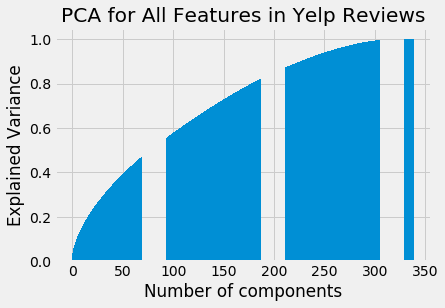

In [127]:
#perform PC decomposition over data311

pca = PCA(X_train_scaled.shape[1])
X_train_scaled_pca=pca.fit_transform(X_train_scaled)
eigenvalues = pca.explained_variance_ratio_
#plot explained variance over the number of compinents
n=X_train_scaled.shape[1]
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.title("PCA for All Features in Yelp Reviews")
plt.savefig("pca_all_features_yelp.png")

In [31]:
pca=PCA(200)
X_train_scaled_pca=pca.fit_transform(X_train_scaled)
X_test_scaled_pca=pca.transform(X_test_scaled)

In [32]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10)

xg_clf.fit(X_train_scaled_pca, y_train)
preds = xg_clf.predict(X_test_scaled_pca)


In [33]:
print("Train Acc Score: ", xg_clf.score(X_train_scaled_pca, y_train))
print("Test Acc Score: ", xg_clf.score(X_test_scaled_pca, y_test))

Train Acc Score:  0.7609288488554665
Test Acc Score:  0.7611039953724745


In [34]:
xg_clf = xgb.XGBClassifier()

In [35]:
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.1, 0.01, 0.001], # `eta` value
              'max_depth': [6,7,8],
              'min_child_weight': [1, 3, 5],
              'subsample': [0.6, 0.8],
              'colsample_bytree': [0.6, 0.8],
              'n_estimators': [5, 10, 15], # trees
              'seed': [123]}

In [36]:
clf = GridSearchCV(xg_clf,
                   parameters,
                   n_jobs=5, 
                   cv=5, 
                   scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'),
                   verbose=1,
                   refit=False)

In [37]:
clf.fit(X_train_scaled_pca, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   39.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 12.9min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 22.1min
[Parallel(n_jobs=5)]: Done 1620 out of 1620 | elapsed: 30.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
             iid='warn', n_jobs=5,
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [6, 7, 8], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [5, 10, 15],
                         'objective': ['binary:logistic'], 'seed': 

In [38]:
best_auc = clf.cv_results_['mean_test_roc_auc'].max()
index_of_best_auc = clf.cv_results_['mean_test_roc_auc'].argmax()

if best_auc != clf.cv_results_['mean_test_roc_auc'][index_of_best_auc]:
    print("mismatch on the best AUC")

print("acc: ", clf.cv_results_['mean_test_accuracy'][index_of_best_auc])
print("precision: ", clf.cv_results_['mean_test_precision'][index_of_best_auc])
print("recall: ", clf.cv_results_['mean_test_recall'][index_of_best_auc])
print("AUC: ", clf.cv_results_['mean_test_roc_auc'][index_of_best_auc])
print("F1: ", clf.cv_results_['mean_test_f1'][index_of_best_auc])
print("")
print(clf.estimator)


acc:  0.7606809354598794
precision:  0.5277754822833742
recall:  0.0036261770556729254
AUC:  0.5891948313495294
F1:  0.007194730121891259

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [39]:
clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   30.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  5.9min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 10.8min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 18.0min
[Parallel(n_jobs=5)]: Done 1620 out of 1620 | elapsed: 24.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
             iid='warn', n_jobs=5,
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [6, 7, 8], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [5, 10, 15],
                         'objective': ['binary:logistic'], 'seed': 

In [40]:
best_auc = clf.cv_results_['mean_test_roc_auc'].max()
index_of_best_auc = clf.cv_results_['mean_test_roc_auc'].argmax()

if best_auc != clf.cv_results_['mean_test_roc_auc'][index_of_best_auc]:
    print("mismatch on the best AUC")

print("acc: ", clf.cv_results_['mean_test_accuracy'][index_of_best_auc])
print("precision: ", clf.cv_results_['mean_test_precision'][index_of_best_auc])
print("recall: ", clf.cv_results_['mean_test_recall'][index_of_best_auc])
print("AUC: ", clf.cv_results_['mean_test_roc_auc'][index_of_best_auc])
print("F1: ", clf.cv_results_['mean_test_f1'][index_of_best_auc])
print("")
print(clf.estimator)


acc:  0.7612594000495827
precision:  0.550024117500879
recall:  0.013468835245612994
AUC:  0.6214231165285727
F1:  0.02626991013888792

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [79]:
from xgboost import plot_tree
from xgboost import plot_importance

In [71]:
xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

xg_clf.fit(X_train_scaled, y_train)
preds = xg_clf.predict(X_test_scaled)

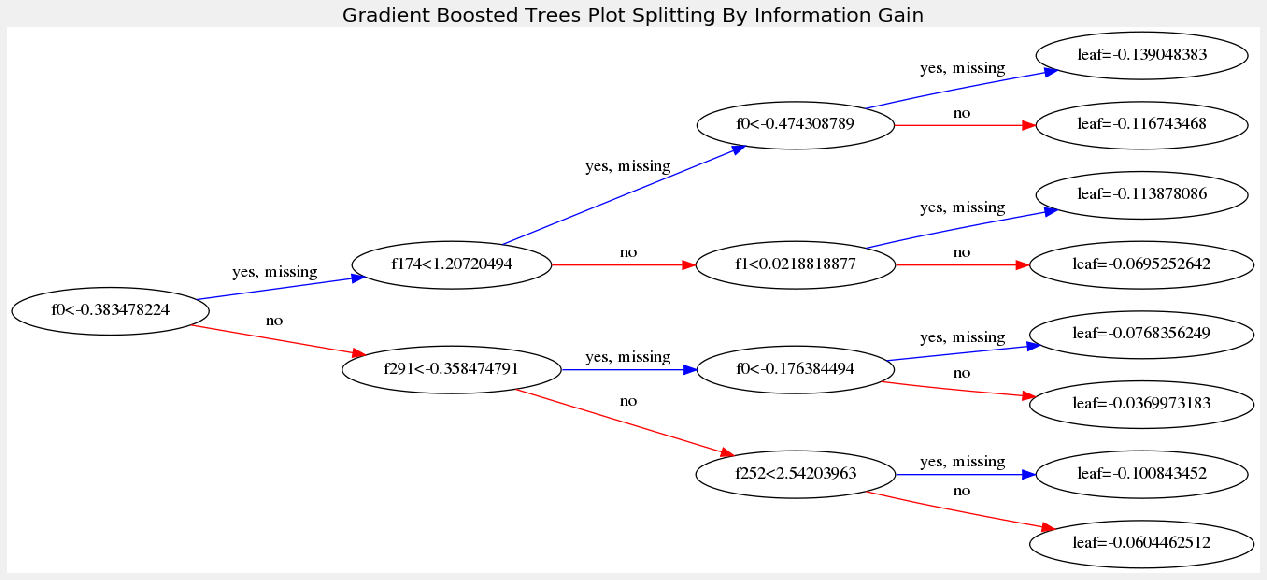

In [125]:

fig, ax = plt.subplots(1,1, figsize=(20,40))

plot_tree(xg_clf, num_trees=0, rankdir='LR', ax=ax)
ax.set_ylabel('Feature Name')
plt.title('Gradient Boosted Trees Plot Splitting By Information Gain')
plt.show()

In [116]:
X.columns[0]

'review_count'

In [117]:
X.columns[174]

'Mexican'

In [118]:
X.columns[291]

'count: service'

In [119]:
X.columns[251]

'Tex-Mex'

In [120]:
X.columns[183]

'Nightlife'

In [98]:
feats = pd.DataFrame({'value':xg_clf.feature_importances_}, X.columns)

Text(0.5, 1.0, 'Top 20 Gradient Boosted Trees Classifier Feature Importance')

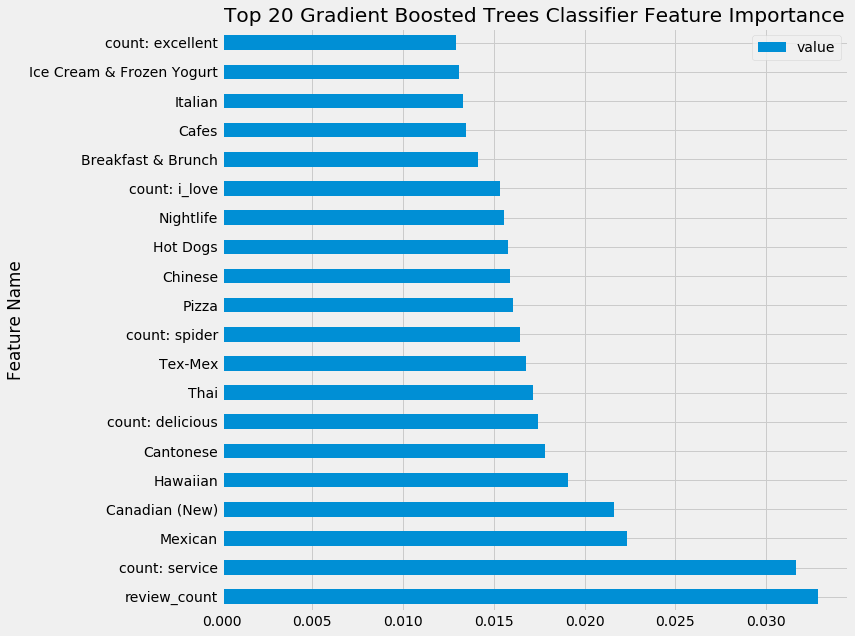

In [110]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1,1, figsize=(10,10))
feats.sort_values('value', ascending=False).head(20).plot.barh(ax=ax)
ax.set_ylabel('Feature Name')
plt.title('Top 20 Gradient Boosted Trees Classifier Feature Importance')